# Covid-19 Vaccine Sentiment Analysis

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
plt.rc('figure',figsize=(17,13))

: 

In [2]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [3]:
f_data = pd.read_csv('vaccination_tweets.csv')
f_data.text =f_data.text.str.lower()

#Remove twitter handlers
f_data.text = f_data.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
f_data.text = f_data.text.apply(lambda x:re.sub(r'\B#\S+','',x))


# Remove URLS
f_data.text = f_data.text.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
f_data.text = f_data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
f_data.text = f_data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
f_data.text = f_data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

## Covid-19 Vaccine Vander Sentiment Analysis

In [4]:
sid = SIA()
f_data['sentiments']           = f_data['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
f_data['Positive Sentiment']   = f_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
f_data['Neutral Sentiment']    = f_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
f_data['Negative Sentiment']   = f_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

f_data.drop(columns=['sentiments'],inplace=True)

## Exploratory Data Analysis

/tmp/ipykernel_99802/2730692178.py:3: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipykernel_99802/2730692178.py:4: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipykernel_99802/2730692178.py:5: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipykernel_99802/2730692178.py:9: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new p

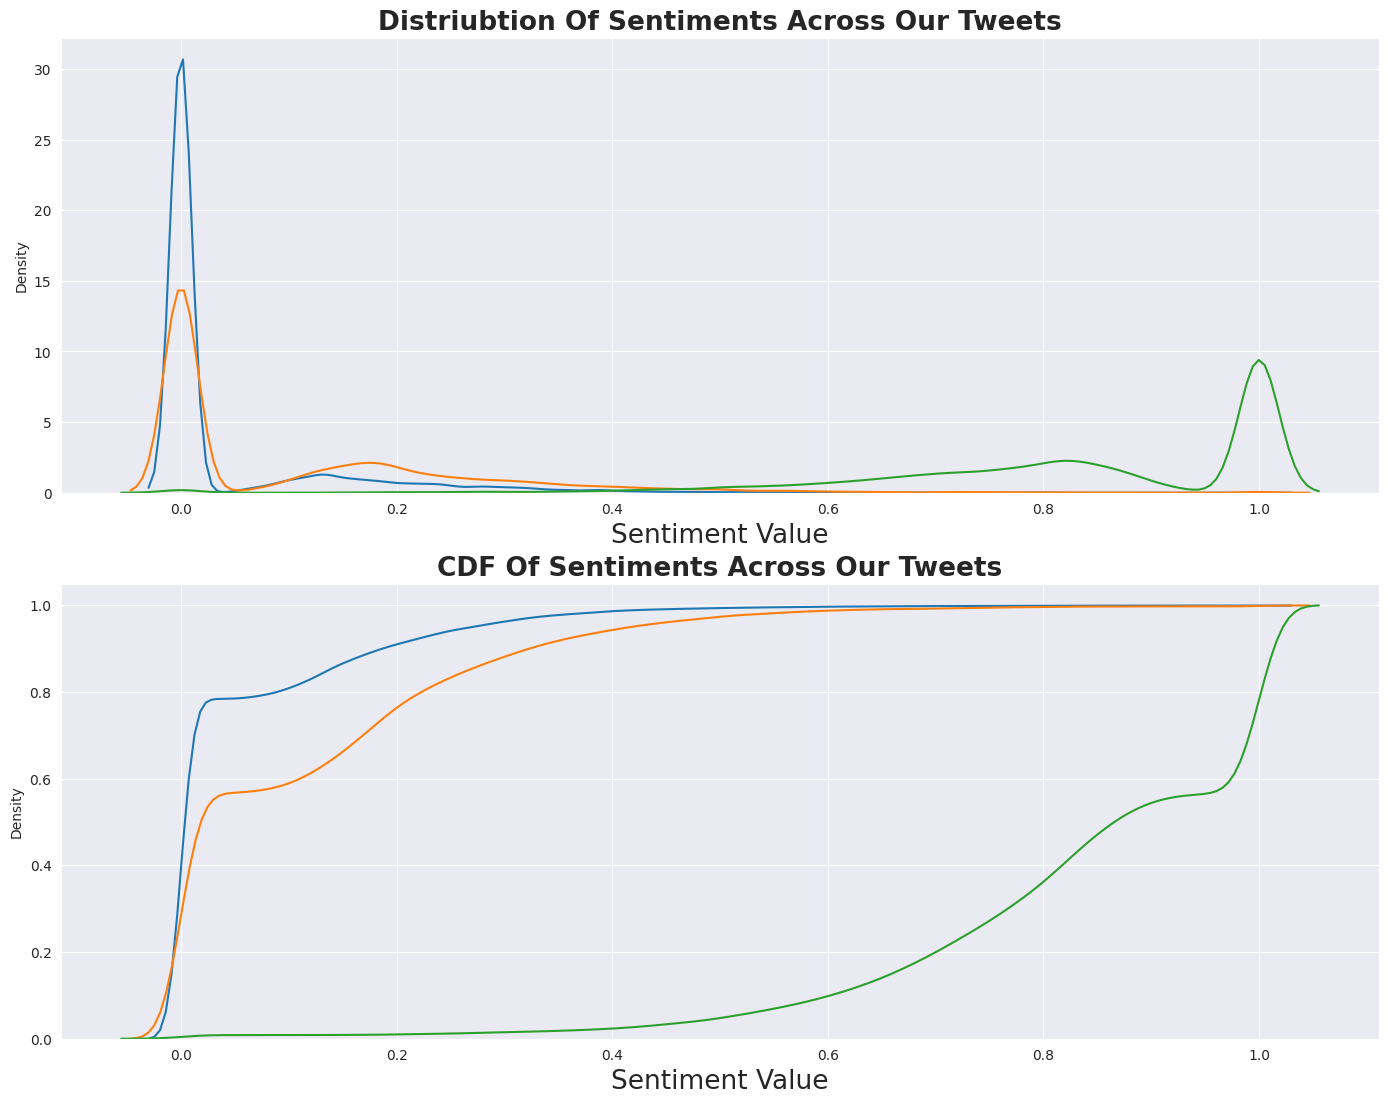

In [5]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(f_data['Negative Sentiment'],bw=0.1)
sns.kdeplot(f_data['Positive Sentiment'],bw=0.1)
sns.kdeplot(f_data['Neutral Sentiment'],bw=0.1)
plt.xlabel('Sentiment Value',fontsize=19)
plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(f_data['Negative Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(f_data['Positive Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(f_data['Neutral Sentiment'],bw=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

## Analyze Sentiments with Python

/tmp/ipykernel_99802/3282500651.py:16: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipykernel_99802/3282500651.py:32: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.




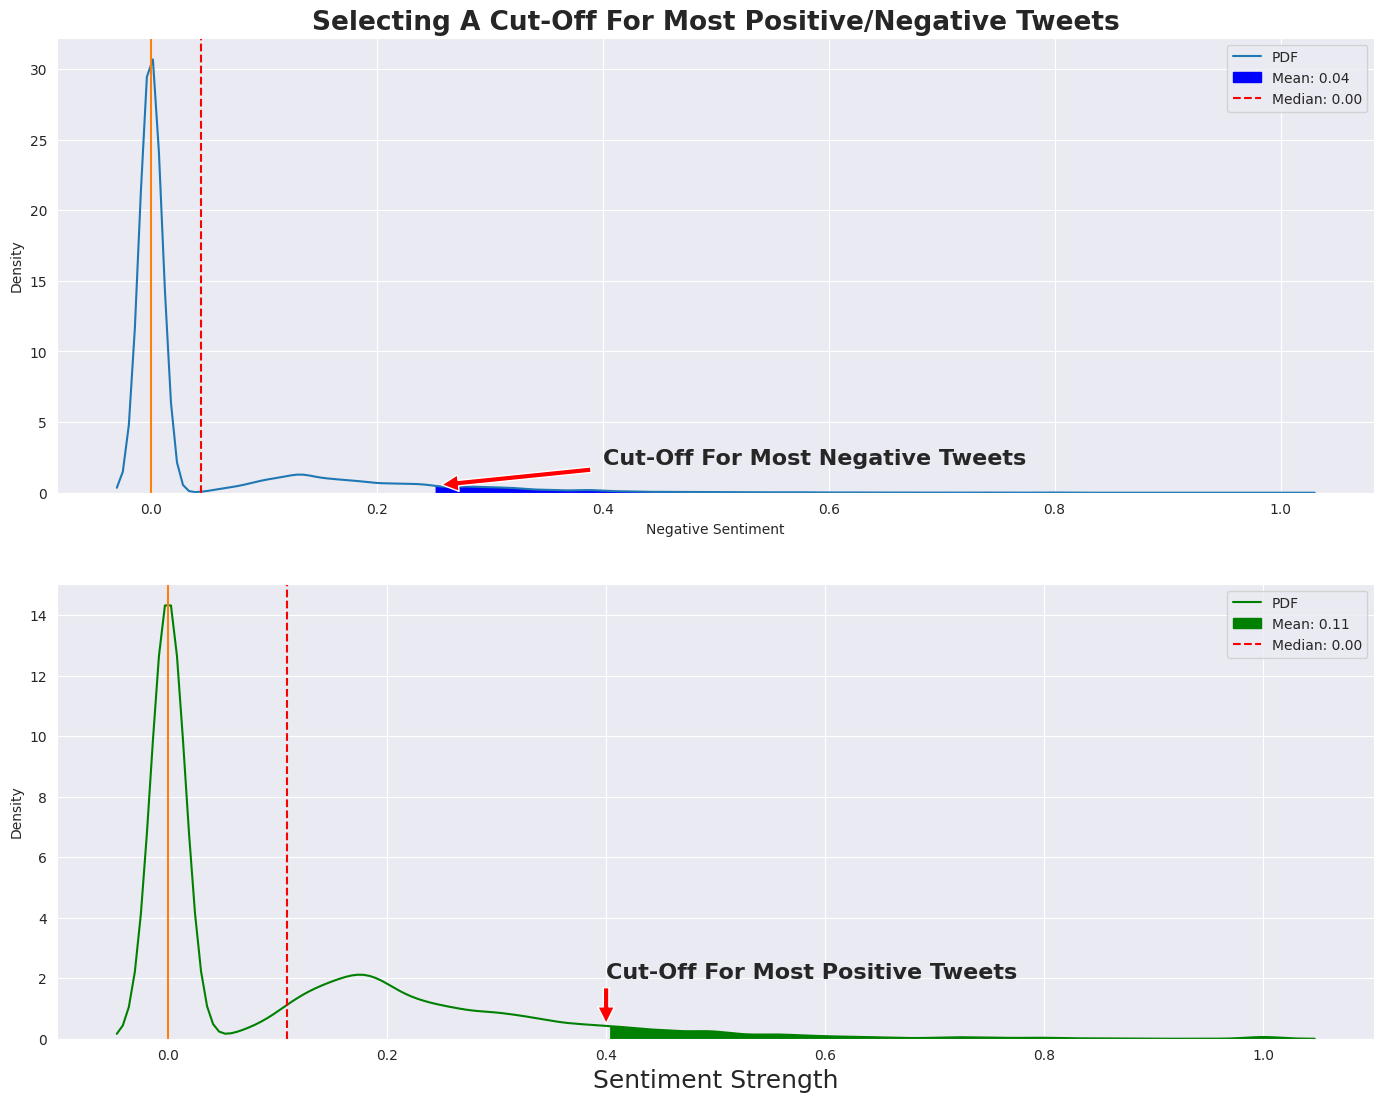

In [6]:
#Sorting And Feature Engineering
f_data = f_data.sort_values(by='date')
ft_data=f_data.copy()
ft_data['date'] = pd.to_datetime(f_data['date']).dt.date

ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1

plt.subplot(2,1,1)
plt.title('Selecting A Cut-Off For Most Positive/Negative Tweets',fontsize=19,fontweight='bold')

ax0 = sns.kdeplot(f_data['Negative Sentiment'],bw=0.1)

kde_x, kde_y = ax0.lines[0].get_data()
ax0.fill_between(kde_x, kde_y, where=(kde_x>0.25) , 
                interpolate=True, color='b')

plt.annotate('Cut-Off For Most Negative Tweets', xy=(0.25, 0.5), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')

ax0.axvline(f_data['Negative Sentiment'].mean(), color='r', linestyle='--')
ax0.axvline(f_data['Negative Sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':f_data['Negative Sentiment'],r'Mean: {:.2f}'.format(f_data['Negative Sentiment'].mean()):f_data['Negative Sentiment'].mean(),
            r'Median: {:.2f}'.format(f_data['Negative Sentiment'].median()):f_data['Negative Sentiment'].median()})

plt.subplot(2,1,2)

ax1 = sns.kdeplot(f_data['Positive Sentiment'],bw=0.1,color='green')

plt.annotate('Cut-Off For Most Positive Tweets', xy=(0.4, 0.43), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')
kde_x, kde_y = ax1.lines[0].get_data()
ax1.fill_between(kde_x, kde_y, where=(kde_x>0.4) , 
                interpolate=True, color='green')
ax1.set_xlabel('Sentiment Strength',fontsize=18)


ax1.axvline(f_data['Positive Sentiment'].mean(), color='r', linestyle='--')
ax1.axvline(f_data['Positive Sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':f_data['Positive Sentiment'],r'Mean: {:.2f}'.format(f_data['Positive Sentiment'].mean()):f_data['Positive Sentiment'].mean(),
            r'Median: {:.2f}'.format(f_data['Positive Sentiment'].median()):f_data['Positive Sentiment'].median()})

plt.show()

## visualize the most negative and the most positive sentiments

In [7]:
Most_Positive = f_data[f_data['Positive Sentiment'].between(0.4,1)]
Most_Negative = f_data[f_data['Negative Sentiment'].between(0.25,1)]

Most_Positive_text = ' '.join(Most_Positive.text)
Most_Negative_text = ' '.join(Most_Negative.text)


pwc = WordCloud(width=600,height=400,collocations = False).generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False).generate(Most_Negative_text)

plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

ValueError: Only supported for TrueType fonts

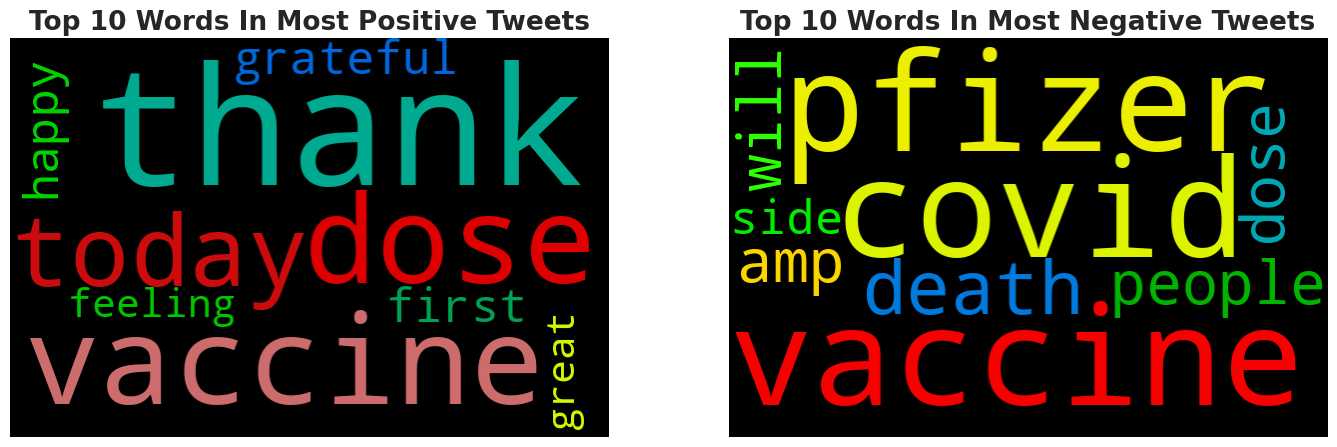

In [10]:
l_t = Most_Positive_text

w1_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w,0)+1
w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1],reverse=True)}

l_t = Most_Negative_text
w2_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w2_dict[w] = w2_dict.get(w,0)+1
w2_dict = {k: v for k, v in sorted(w2_dict.items(), key=lambda item: item[1],reverse=True)}

top_10_pos = list(w1_dict.keys())[:10]
top_10_neg = list(w2_dict.keys())[:10]

plt.subplot(1,2,1)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral').generate(' '.join(top_10_pos))
plt.title('Top 10 Words In Most Positive Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.subplot(1,2,2)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral').generate(' '.join(top_10_neg))
plt.title('Top 10 Words In Most Negative Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()